# Introduction to Data Science

## Project: Global Refinement of Random Forest

### 1. Introduction

This Juptyer Notebook is used as part of Introduction to Data Science course's project task which will present the Global Refinement of Random Forest (https://openaccess.thecvf.com/content_cvpr_2015/papers/Ren_Global_Refinement_of_2015_CVPR_paper.pdf) by Shaoqing Ren et al. In the first part of the project proposed approach from the given paper will be evaluated on standard machine learning tasks:
- MNIST: https://archive.ics.uci.edu/ml/machine-learning-databases/mnist-mld/
- covtype: https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/

for classification and:
- abalone
- ailerons

for regression problems.

Later on, the evaluation of the proposed approach will be made on the real world application - namely the one solving the classification problem.

### 2. Standard machine learning tasks

### 2.1 Classification: MNIST 

Since it will be used for MNIST dataset import from already prepared sources which keras.datasets offers it is necessary to include `tensorflow` library by simply commenting out the next code cell and executing it.

In [1]:
# pip install tensorflow

Here are listed all imports which are going to be used later in the code. It is always possible to return back here later in case that you want to add some others or remove existing ones. 

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

from sklearn.metrics import zero_one_loss
from sklearn.metrics import hinge_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from utils.RefinedRandomForest import RefinedRandomForest

Here comes the importing dataset part. Since it is fairly common MNIST dataset is already present in large share of different libraries - in this case keras.dataset module will be used to importing. For some other dataset used later in the project this will not be the case, so the dataset will have to be downloaded locally and imported from there.

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape((60000,784))
X_test = X_test.reshape((10000,784))

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [4]:
print(f'Number of train examples: {X_train.shape[0]}')
print(f'Number of test examples: {y_test.shape[0]}')
print(f'Number of features: {len(X_train[0])}')
print(f'Number of classes: {len(np.unique(y_test))}')

Number of train examples: 60000
Number of test examples: 10000
Number of features: 784
Number of classes: 10


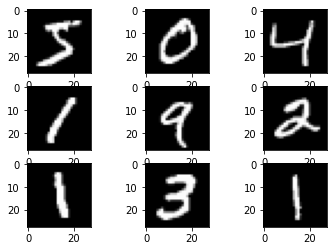

In [5]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(np.array(X_train[i]).reshape((28,28)), cmap=plt.get_cmap('gray'))
plt.show()

After reviewing the MNIST dataset it is now time to train Random Forest Classifier on the given data and try the proposed approach from the paper. For that reason, `run_classification_experiment` function is defined to train the given model on training dataset and return zero-one loss calculated on testing dataset.

In [6]:
def run_classification_experiment(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    loss = zero_one_loss(y_test, y_pred)

    return loss

In [7]:
ITER = 2

errors_rfc = []
errors_rrf = []

for iter in range(ITER):
    # split data into training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)
    
    # train regular RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators=100, min_samples_split=5, max_features='sqrt')
    error_rfc = run_classification_experiment(rfc, X_train, y_train, X_test, y_test)
    
    # train refined RandomForestClassifier
    rrf = RefinedRandomForest(rfc, C = 0.01, n_prunings = 0)
    error_rrf = run_classification_experiment(rrf, X_train, y_train, X_test, y_test)
    
    # save errors for both models
    errors_rfc.append(error_rfc)
    errors_rrf.append(error_rrf)

average_error_rfc = sum(errors_rfc)/ITER
standard_deviation_rfc = np.std(errors_rfc)

average_error_rrf = sum(errors_rrf)/ITER
standard_deviation_rrf = np.std(errors_rrf)

print('Regular Random Forest Classifier')
print(f'Average error: {average_error_rfc}')
print(f'Standard deviation: {standard_deviation_rfc}')

print('Refined Random Forest Classifier')
print(f'Average error: {average_error_rrf}')
print(f'Standard deviation: {standard_deviation_rrf}')

print(f'Compression Ratio: {rfc.n_leaves_/nleaves[-1]}')

Regular Random Forest Classifier
Average error: 0.032799999999999996
Standard deviation: 0.0013000000000000234
Refined Random Forest Classifier
Average error: 0.0257
Standard deviation: 0.0007999999999999674


In [8]:
rrf.n_prunings = 1 # do one pruning in each iteration
trainloss = []
testloss = []
nleaves = [sum(rrf.n_leaves_)] # remember number of leaves in each iteration
for k in range(100):
    rrf.fit(X_train, y_train) # fit and do 1 pruning
    loss4tr = zero_one_loss(y_train, rrf.predict(X_train))
    loss4te = zero_one_loss(y_test, rrf.predict(X_test))
    trainloss.append(loss4tr)
    testloss.append(loss4te)
    nleaves.append(sum(rrf.n_leaves_))
    print("Pruning {:02d}: train loss {:.4f}, test loss {:.4f}".format(k+1, loss4tr, loss4te))
    if loss4te > average_error_rfc:
        break # stop when test error increases too much


Pruning 01: train loss 0.0000, test loss 0.0262
Pruning 02: train loss 0.0000, test loss 0.0264
Pruning 03: train loss 0.0000, test loss 0.0258
Pruning 04: train loss 0.0000, test loss 0.0252
Pruning 05: train loss 0.0000, test loss 0.0248
Pruning 06: train loss 0.0000, test loss 0.0239
Pruning 07: train loss 0.0000, test loss 0.0240
Pruning 08: train loss 0.0000, test loss 0.0238
Pruning 09: train loss 0.0000, test loss 0.0245
Pruning 10: train loss 0.0001, test loss 0.0240
Pruning 11: train loss 0.0002, test loss 0.0234
Pruning 12: train loss 0.0002, test loss 0.0236
Pruning 13: train loss 0.0004, test loss 0.0233
Pruning 14: train loss 0.0004, test loss 0.0229
Pruning 15: train loss 0.0004, test loss 0.0228
Pruning 16: train loss 0.0006, test loss 0.0232
Pruning 17: train loss 0.0007, test loss 0.0230
Pruning 18: train loss 0.0009, test loss 0.0225
Pruning 19: train loss 0.0010, test loss 0.0236
Pruning 20: train loss 0.0012, test loss 0.0238
Pruning 21: train loss 0.0014, test loss

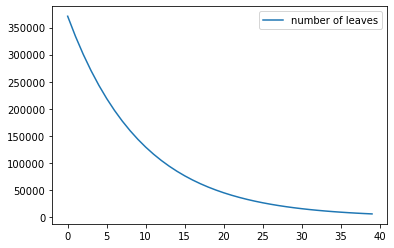

Compression Ratio: 60.85018050541516


In [21]:
plt.plot(np.arange(len(nleaves)), nleaves, label='number of leaves')

plt.legend(loc='best')
plt.show()

print(f'Compression Ratio: {nleaves[0]/nleaves[-1]}')

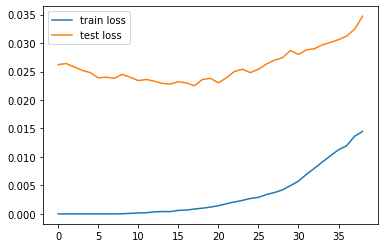

In [18]:
plt.plot(np.arange(len(trainloss)), trainloss, label='train loss')
plt.plot(np.arange(len(testloss)), testloss, label='test loss')

plt.legend(loc='best')
plt.show()

After running these experiments it is visible that error drops when refined random forest fitted to the given MNIST datasets. It is also possible to execute pruning process on pre-trained random forest model to save space by reducing total number of leaves keeping the accuracy approximately equal. 

### 2.2 Classification: covtype 

This is the second example solving the classification problem and it includes predicting forest cover type from cartographic variables only (no remotely sensed data). The workflow is standard: 
1. importing given covtype dataset
2. training standard random forest classifier
3. training refined random forest classifier
4. pruning refined random forest classifier

Since this dataset is not accessible for import using standard libraries such as keras it will previously be downloaded from the source given in the **Introduction** and then read using common `read_csv` funtion from `pandas` library.

In [9]:
column_headers = pd.read_csv('./covtype/train.csv').columns[1:]
trees = pd.read_csv("./covtype/covtype.data", sep=",", header=None, names=column_headers)
trees.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [10]:
ITER = 2

errors_rfc = []
errors_rrf = []

for iter in range(ITER):
    # split data into training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(trees.drop(['Cover_Type'], axis='columns'), trees.Cover_Type, test_size=232405)    
    
    # train regular RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators=100, min_samples_split=5, max_features='sqrt')
    error_rfc = run_classification_experiment(rfc, X_train, y_train, X_test, y_test)
    
    # train refined RandomForestClassifier
    rrf = RefinedRandomForest(rfc, C = 0.01, n_prunings = 0)
    error_rrf = run_classification_experiment(rrf, X_train, y_train, X_test, y_test)
    
    # save errors for both models
    errors_rfc.append(error_rfc)
    errors_rrf.append(error_rrf)

average_error_rfc = sum(errors_rfc)/ITER
standard_deviation_rfc = np.std(errors_rfc)

average_error_rrf = sum(errors_rrf)/ITER
standard_deviation_rrf = np.std(errors_rrf)

print('Regular Random Forest Classifier')
print(f'Average error: {average_error_rfc}')
print(f'Standard deviation: {standard_deviation_rfc}')

print('Refined Random Forest Classifier')
print(f'Average error: {average_error_rrf}')
print(f'Standard deviation: {standard_deviation_rrf}')

KeyboardInterrupt: 

In [ ]:
rrf.n_prunings = 1 # do one pruning in each iteration
trainloss = []
testloss = []
nleaves = [sum(rrf.n_leaves_)] # remember number of leaves in each iteration
for k in range(100):
    rrf.fit(X_train, y_train) # fit and do 1 pruning
    loss4tr = zero_one_loss(y_train, rrf.predict(X_train))
    loss4te = zero_one_loss(y_test, rrf.predict(X_test))
    trainloss.append(loss4tr)
    testloss.append(loss4te)
    nleaves.append(sum(rrf.n_leaves_))
    print("Pruning {:02d}: train loss {:.4f}, test loss {:.4f}".format(k+1, loss4tr, loss4te))
    if loss4te > average_error_rfc:
        break # stop when test error increases too much

### 2.3 Regression: abalone

Here comes the second part of our **Standard machine learning tasks** where refined random forest will be tested on regression problems specifically abalone and ailerons tasks which will be described in details as we move on. 

In [ ]:
# Load data from URL using pandas read_csv method
column_headers = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
abalone = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', header=None, names=column_headers)
abalone.head()

In [ ]:
gender = {'I': 0, 'M': 1,'F': 2}
abalone.Sex = [gender[item] for item in abalone.Sex]
abalone.head()

In [ ]:
def run_regression_experiment(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    error = mean_squared_error(y_test, y_pred)

    return np.sqrt(error)

In [ ]:
ITER = 2

errors_rfc = []
errors_rrf = []

for iter in range(ITER):
    # split data into training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(abalone.drop(['Rings'], axis='columns'), abalone.Rings, test_size=1671)
   
    # train regular RandomForestRegressor
    rfc = RandomForestRegressor(n_estimators=100, min_samples_split=5, max_features='sqrt')
    error_rfc = run_regression_experiment(rfc, X_train, y_train, X_test, y_test)
    
    # train refined RandomForestClassifier
    rrf = RefinedRandomForest(rfc, C = 0.01, n_prunings = 0)
    error_rrf = run_regression_experiment(rrf, X_train, y_train, X_test, y_test)
    
    # save errors for both models
    errors_rfc.append(error_rfc)
    errors_rrf.append(error_rrf)

average_error_rfc = sum(errors_rfc)/ITER
standard_deviation_rfc = np.std(errors_rfc)

average_error_rrf = sum(errors_rrf)/ITER
standard_deviation_rrf = np.std(errors_rrf)

print('Regular Random Forest Classifier')
print(f'Average error: {average_error_rfc}')
print(f'Standard deviation: {standard_deviation_rfc}')

print('Refined Random Forest Classifier')
print(f'Average error: {average_error_rrf}')
print(f'Standard deviation: {standard_deviation_rrf}')

In [ ]:
rrf.n_prunings = 1 # do one pruning in each iteration
trainloss = []
testloss = []
nleaves = [sum(rrf.n_leaves_)] # remember number of leaves in each iteration
for k in range(100):
    rrf.fit(X_train, y_train) # fit and do 1 pruning
    loss4tr = zero_one_loss(y_train, rrf.predict(X_train))
    loss4te = zero_one_loss(y_test, rrf.predict(X_test))
    trainloss.append(loss4tr)
    testloss.append(loss4te)
    nleaves.append(sum(rrf.n_leaves_))
    print("Pruning {:02d}: train loss {:.4f}, test loss {:.4f}".format(k+1, loss4tr, loss4te))
    if loss4te > average_error_rfc:
        break # stop when test error increases too much

### 2.4 Regression: ailerons

In [ ]:
ailerons = pd.read_csv("./ailerons/ailerons.csv")
ailerons.head()

In [ ]:
ITER = 2

errors_rfc = []
errors_rrf = []

for iter in range(ITER):
    # split data into training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(ailerons.drop(['goal'], axis='columns'), ailerons.goal, test_size=6596)
    
    # train regular RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators=100, min_samples_split=5, max_features='sqrt')
    error_rfc = run_regression_experiment(rfc, X_train, y_train, X_test, y_test)
    
    # train refined RandomForestClassifier
    rrf = RefinedRandomForest(rfc, C = 0.01, n_prunings = 0)
    error_rrf = run_regression_experiment(rrf, X_train, y_train, X_test, y_test)
    
    # save errors for both models
    errors_rfc.append(error_rfc)
    errors_rrf.append(error_rrf)

average_error_rfc = sum(errors_rfc)/ITER
standard_deviation_rfc = np.std(errors_rfc)

average_error_rrf = sum(errors_rrf)/ITER
standard_deviation_rrf = np.std(errors_rrf)

print('Regular Random Forest Classifier')
print(f'Average error: {average_error_rfc}')
print(f'Standard deviation: {standard_deviation_rfc}')

print('Refined Random Forest Classifier')
print(f'Average error: {average_error_rrf}')
print(f'Standard deviation: {standard_deviation_rrf}')

In [ ]:
rrf.n_prunings = 1 # do one pruning in each iteration
trainloss = []
testloss = []
nleaves = [sum(rrf.n_leaves_)] # remember number of leaves in each iteration
for k in range(100):
    rrf.fit(X_train, y_train) # fit and do 1 pruning
    loss4tr = zero_one_loss(y_train, rrf.predict(X_train))
    loss4te = zero_one_loss(y_test, rrf.predict(X_test))
    trainloss.append(loss4tr)
    testloss.append(loss4te)
    nleaves.append(sum(rrf.n_leaves_))
    print("Pruning {:02d}: train loss {:.4f}, test loss {:.4f}".format(k+1, loss4tr, loss4te))
    if loss4te > average_error_rfc:
        break # stop when test error increases too much

### 3. Application II: human age regression